# Lab 3: CRISP-DM Capstone
## Association Rule Mining, Clustering, or Collaborative Filtering

### Ryan Bass, Brett Benefield, Cho Kim, Nicole Wittlin

<a id="top"></a>
## Contents
* Business Understanding
* Data Understanding
    * <a href="#data1">Data Understanding 1</a>
    * <a href="#data2">Data Understanding 2</a>
* Modeling and Evaluation
    * <a href="#Model1">Train and Adjust Parameters</a>
    * <a href="#Model2">Evaluate and Compare</a>
    * <a href="#Model3">Visualize Results</a>
    * <a href="#Model4">Summarize the Ramifications</a>
* <a href="#Deployment">Deployment</a>
* <a href="#Exceptional">Exceptional Work</a>


In [1]:
# Display plots below cells
%matplotlib notebook

# Turn off annoying warnings
import warnings
warnings.filterwarnings("ignore")

In [28]:
import pandas as pd
import numpy as np
import yellowbrick as yb
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from pprint import pprint
from time import time
from datetime import datetime
from sklearn import metrics as mt
from sklearn import neighbors
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, SelectPercentile, f_regression, mutual_info_regression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, accuracy_score, f1_score, roc_auc_score, mean_absolute_error, make_scorer, mean_squared_error, silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, Binarizer, scale
from sklearn.svm import LinearSVC, NuSVC, SVC, SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier, RidgeClassifier, LinearRegression
from sklearn.linear_model import Ridge, Lasso, LassoCV
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, ShuffleSplit, StratifiedShuffleSplit, StratifiedKFold, GridSearchCV, cross_validate, RandomizedSearchCV, cross_val_score
from sklearn.cluster import KMeans, MiniBatchKMeans
from yellowbrick.classifier import ClassificationReport, ConfusionMatrix, ClassPredictionError, ROCAUC
from yellowbrick.features import Rank1D, Rank2D, RFECV
from yellowbrick.features.importances import FeatureImportances
from yellowbrick.model_selection import ValidationCurve, LearningCurve
from yellowbrick.regressor import PredictionError, ResidualsPlot
from yellowbrick.regressor.alphas import AlphaSelection
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer

In [2]:
# Show all columns/rows in output
pd.set_option('max_rows', None)
pd.set_option('max_columns', None)

### Slack Integration

In [3]:
# Some setup is required before you can use this because token must be kept private
# I also need to add your name and unique identifier to the dictionary userID below
import os
from slackclient import SlackClient
from dotenv import load_dotenv

load_dotenv()

userID = {"brett": "UAN6UQEVC", "ryan": "UALUD69AB"}

#slackToken = os.environ["SLACK_BOT_TOKEN"]
#sc = SlackClient(slackToken)

def sendSlackMessage(msg, user):
    result = sc.api_call(
    "chat.postMessage",
    channel=userID[user.lower()],
    text=msg)
    
    if (not result['ok']):
        print("Error: {}".format(result))

ModuleNotFoundError: No module named 'slackclient'

### Supporting Functions

In [4]:
# Source: https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d
def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha="right")
    plt.show()
    
def getTopCoefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    feature_names = np.array(feature_names)
    return feature_names[top_coefficients]

# Source: https://stackoverflow.com/questions/39812885/retain-feature-names-after-scikit-feature-selection
def percentile_threshold_selector(data, percent=10):
    selector = SelectPercentile(f_classif, percentile = percent)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

def scale_data(data):
    temp = scaler.fit(data)
    data = pd.DataFrame(temp, columns = data.columns)
    return data

# https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

# rmse, mape functions take from :https://github.com/jakemdrew/EducationDataNC/blob/master/Other%20Projects/iPython%20Notebooks/Machine%20Learning/High%20School%20Minority%20Percentage%20February%202018.ipynb
#Use mean absolute error (MAE) to score the regression models created 
#(the scale of MAE is identical to the response variable)

#Function for Root mean squared error
#https://stackoverflow.com/questions/17197492/root-mean-square-error-in-python
def rmse(y_actual, y_predicted):
    return np.sqrt(mean_squared_error(y_actual, y_predicted))

#Function for Mean Absolute Percentage Error (MAPE) - Untested
#Adapted from - https://stackoverflow.com/questions/42250958/how-to-optimize-mape-code-in-python
def mape(y_actual, y_predicted): 
    mask = y_actual != 0
    return (np.fabs(y_actual - y_predicted)/y_actual)[mask].mean() * 100

#Create scorers for rmse and mape functions
mae_scorer = make_scorer(score_func=mean_absolute_error, greater_is_better=False)
rmse_scorer = make_scorer(score_func=rmse, greater_is_better=False)
mape_scorer = make_scorer(score_func=mape, greater_is_better=False)

#Make scorer array to pass into cross_validate() function for producing mutiple scores for each cv fold.
errorScoring = {'MAE':  mae_scorer, 
                'RMSE': rmse_scorer,
                'MAPE': mape_scorer
               }

In [5]:
# code used to evaluate regression models used
# code from Dr. Drew github: https://github.com/jakemdrew/EducationDataNC/blob/master/Other%20Projects/iPython%20Notebooks/Machine%20Learning/High%20School%20Minority%20Percentage%20February%202018.ipynb

def EvaluateRegressionEstimator(regEstimator, X, y, cv):
    
    scores = cross_validate(regEstimator, X, y, scoring=errorScoring, cv=cv, return_train_score=True)

    #cross val score sign-flips the outputs of MAE
    # https://github.com/scikit-learn/scikit-learn/issues/2439
    scores['test_MAE'] = scores['test_MAE'] * -1
    scores['test_MAPE'] = scores['test_MAPE'] * -1
    scores['test_RMSE'] = scores['test_RMSE'] * -1

    #print mean MAE for all folds 
    maeAvg = scores['test_MAE'].mean()
    print_str = "The average MAE for all cv folds is: \t\t\t {maeAvg:.5}"
    print(print_str.format(maeAvg=maeAvg))

    #print mean test_MAPE for all folds
    scores['test_MAPE'] = scores['test_MAPE']
    mape_avg = scores['test_MAPE'].mean()
    print_str = "The average MAE percentage (MAPE) for all cv folds is: \t {mape_avg:.5}"
    print(print_str.format(mape_avg=mape_avg))

    #print mean MAE for all folds 
    RMSEavg = scores['test_RMSE'].mean()
    print_str = "The average RMSE for all cv folds is: \t\t\t {RMSEavg:.5}"
    print(print_str.format(RMSEavg=RMSEavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['MAE'] = scores['test_MAE']
    scoresResults['MAPE'] = scores['test_MAPE']
    scoresResults['RMSE'] = scores['test_RMSE']
    return scoresResults

In [6]:
# Brett's directory
# Laptop
%cd "C:\sandbox\SMU\dataMining\choNotebook\EducationDataNC\2017\Machine Learning Datasets"

# Ryan's directory
#%cd "C:\Users\Clovis\Documents\7331DataMining\EducationDataNC\2017\Machine Learning Datasets"

# Cho's directory
#%cd "/Users/chostone/Documents/Data Mining/7331DataMining/EducationDataNC/2017/Machine Learning Datasets"

# NW directory
#%cd "C:\Users\Nicole Wittlin\Documents\Classes\MSDS7331\Project\2017\Machine Learning Datasets"

dfPublicHS = pd.read_csv("PublicHighSchools2017_ML.csv")

C:\sandbox\SMU\dataMining\choNotebook\EducationDataNC\2017\Machine Learning Datasets


In [7]:
# These names seem to cause problems so let's give them friendlier names
# renameCols = {'_1yr_tchr_trnovr_pct': 'One_yr_tchr_trnovr_pct',
#               '0-3 Years_LEA_Exp_Pct_Prin': 'less_3_years_LEA_Exp_Pct_Prin',
#               '10+ Years_LEA_Exp_Pct_Prin': 'ten_plus_years_LEA_Exp_Pct_Prin',
#               '4-10 Years_LEA_Exp_Pct_Prin': 'four_plus_years_LEA_Exp_Pct_Prin',
#               '4-Year_Cohort_Graduation_Rate_Score': 'four_Year_Cohort_Graduation_Rate_Score',
#               '_1_to_1_access_Yes': 'one_to_one_access_yes',
#               '4_10_Years_LEA_Exp_Pct_Prin': 'Four_to_Ten_Years_Exp_Pct_prin',
#               '10+_Years_LEA_Exp_Pct_Prin': 'Ten_Plus_Years_LEA_Exp_Pct_prin',
#               '0_3_Years_LEA_Exp_Pct_Prin': 'One_to_three_lea_exp_pct_prin'}

# # Rename columns
# dfPublicHS.rename(columns=renameCols, inplace = True)

In [8]:
# Replace all non alphanumeric characters with underscores
dfPublicHS.columns = dfPublicHS.columns.str.replace(r'\W', "_")

In [9]:
# Change all columns to floats since some libraries only work with floats
dfPublicHS = dfPublicHS.astype(float)

# Treat unit_code as a string
dfPublicHS["unit_code"] = dfPublicHS.astype({"unit_code": str})

In [10]:
#want to delete any remaining variables related to the ACT score (such as ACT benchmarks) to not bias our model
dfDropped = dfPublicHS

temp = dfDropped['ACT_Score']

dropCols = dfDropped.filter(regex = r'ACT')

dfDropped.drop(dropCols, axis = 1, inplace = True)

dfDropped['ACT_Score'] = temp

In [11]:
#list of all the columns that were deleted (note that ACT Score was put back into dataframe that is being used)
#dropCols.info()

In [12]:
dropColsPrin = dfDropped.filter(regex = r'prin')

dfDropped.drop(dropColsPrin, axis = 1, inplace = True)

#dropColsPrin.info()

#### Determine the 25% and 75% quartile. 

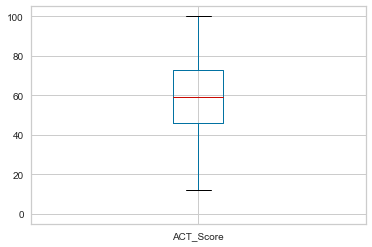

In [13]:
fig = plt.figure()
ax = fig.add_subplot()

dfDropped.boxplot(column=['ACT_Score'])
qSplit = dfDropped['ACT_Score'].quantile([.25, .50, .75, 1])

#### We want to explore the extremes

In [14]:
dfDropped["Q25"] = np.where(dfDropped['ACT_Score'] <= qSplit[.25], 1.0, 0.0)
dfDropped["Q50"] = np.where(dfDropped['ACT_Score'] <= qSplit[.50], 1.0, 0.0)
dfDropped["Q75"] = np.where(dfDropped['ACT_Score'] <= qSplit[.75], 1.0, 0.0)
dfDropped["Q100"] = np.where(dfDropped['ACT_Score'] <= qSplit[1], 1.0, 0.0)

<a href="#top">Back to Top</a> 
## Business Understanding (10 points total)

<span style="color: blue">Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). How will you measure the effectiveness of a good algorithm? Why does your chosen validation method make sense for this specific dataset and the stakeholders needs?</span>

<a href="#top">Back to Top</a> 
## Data Understanding (20 points total)
<a id="data1"></a>
### Data Understanding 1 (10 points)

<span style="color: blue">Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file. Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems?</span>

<a href="#top">Back to Top</a> 
<a id="data2"></a>
### Data Understanding 2 (10 points)

<span style="color: blue">Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.

<span style="color: blue">Note: "Visualize the any" is verbatim from syllabus</span>


In [15]:
zeroScore = dfDropped[dfDropped['ACT_Score'] == 0]
zeroScore[['student_num', 'ACT_Score']]

,student_num,ACT_Score
8,56.0,0.0
16,64.0,0.0
51,62.0,0.0
78,8.0,0.0
187,443.0,0.0
311,68.0,0.0
332,46.0,0.0
340,149.0,0.0
353,502.0,0.0
463,59.0,0.0


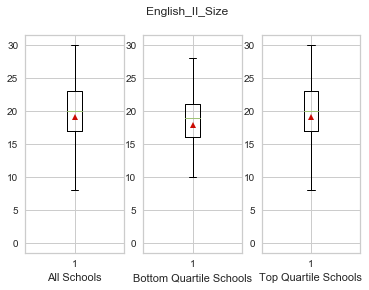

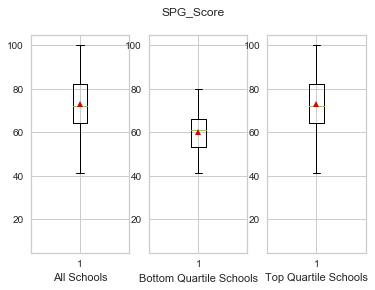

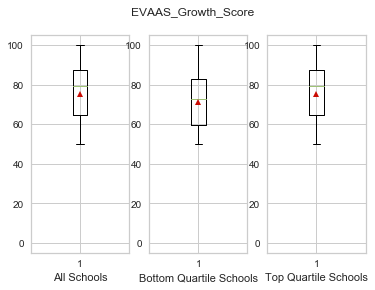

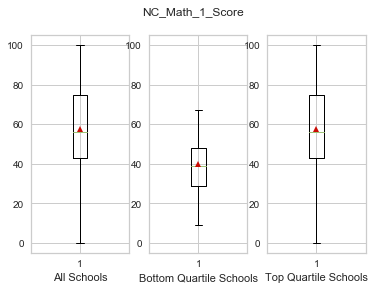

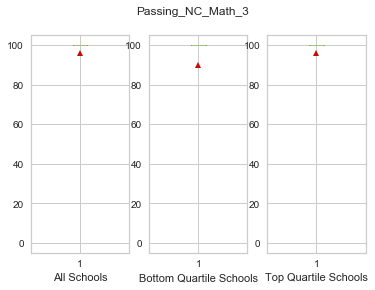

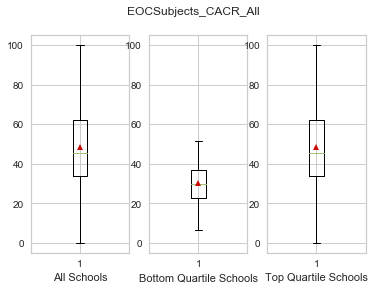

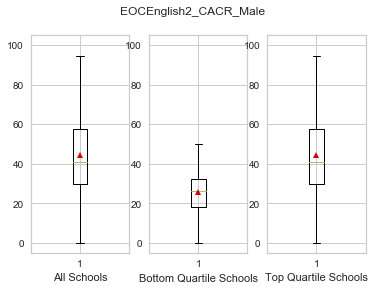

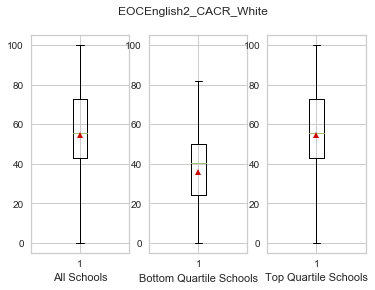

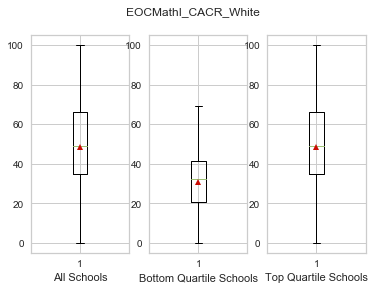

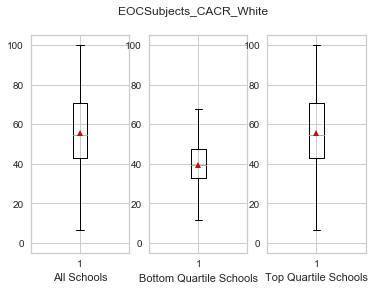

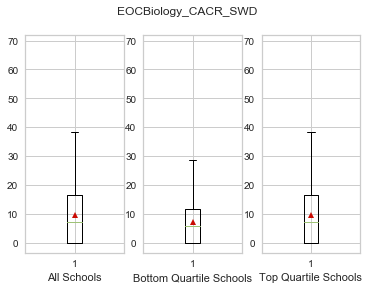

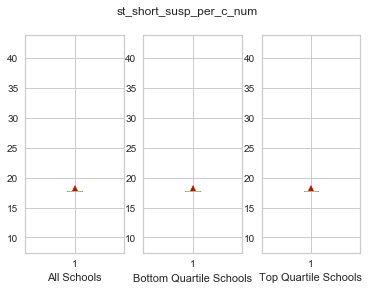

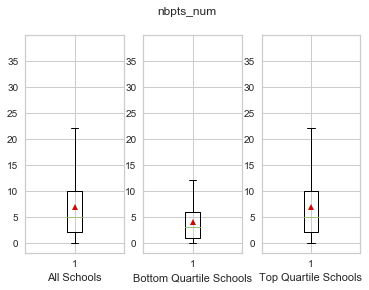

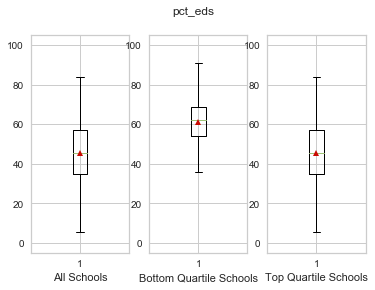

In [16]:
featCols = ['English_II_Size', 'SPG_Score', 'EVAAS_Growth_Score', 'NC_Math_1_Score', 
            'Passing_NC_Math_3', 'EOCSubjects_CACR_All', 'EOCEnglish2_CACR_Male',
            'EOCEnglish2_CACR_White', 'EOCMathI_CACR_White', 'EOCSubjects_CACR_White',
            'EOCBiology_CACR_SWD', 'st_short_susp_per_c_num', 'nbpts_num', 'pct_eds']

for feat in featCols:
    fig = plt.figure()
    fig.suptitle(feat)

    ax = fig.add_subplot(131)
    plt.boxplot(dfDropped[feat], showmeans=True)
    ax.set_xlabel('All Schools')

    ax = fig.add_subplot(132, sharey=ax)
    btmQ = dfDropped[dfDropped['Q25'] == 1]
    plt.boxplot(btmQ[feat], showmeans=True)
    ax.set_xlabel('Bottom Quartile Schools')

    ax = fig.add_subplot(133, sharey=ax)
    topQ = dfDropped[dfDropped['Q100'] == 1]
    plt.boxplot(topQ[feat], showmeans=True)
    ax.set_xlabel('Top Quartile Schools')

In [17]:
breaks = np.asarray(np.percentile(dfDropped['ACT_Score'], [25,50,75,100]))
dfDropped['ACT_Score_Quartiles'] = (dfDropped['ACT_Score'].values > breaks[..., np.newaxis]).sum(0)

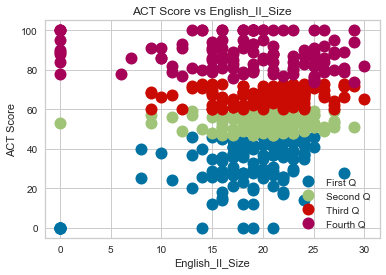

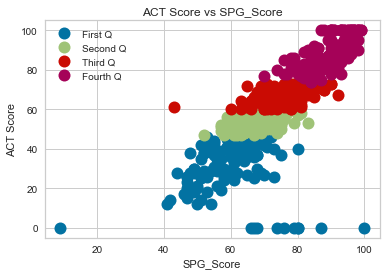

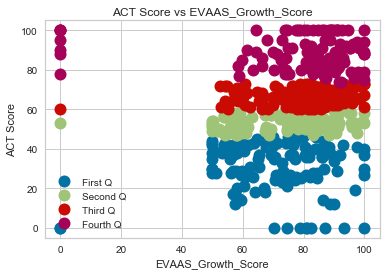

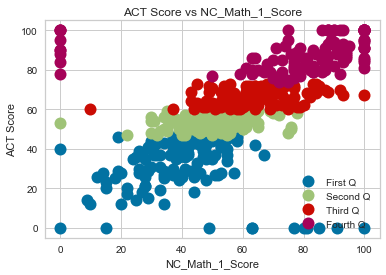

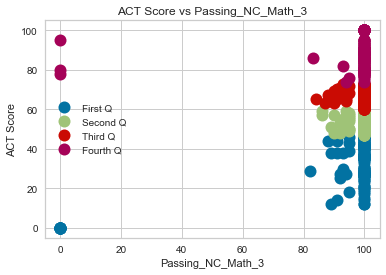

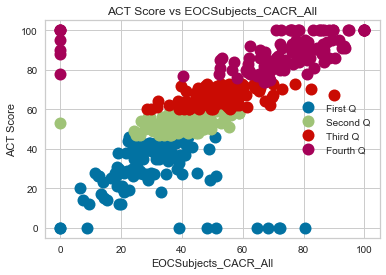

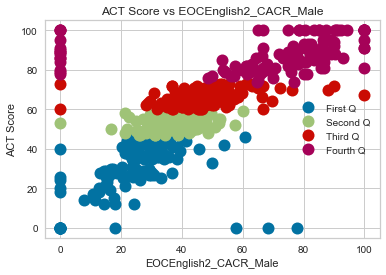

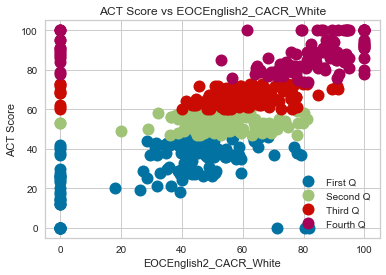

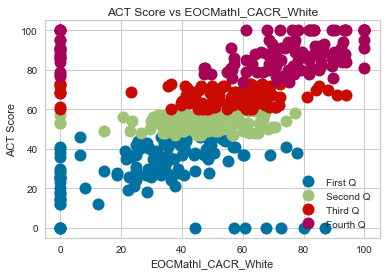

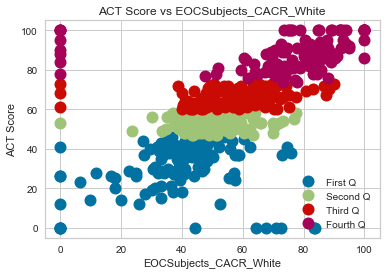

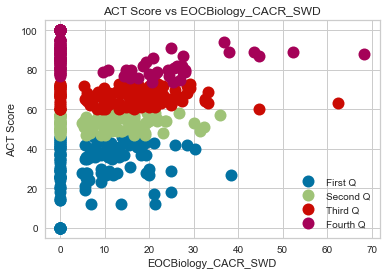

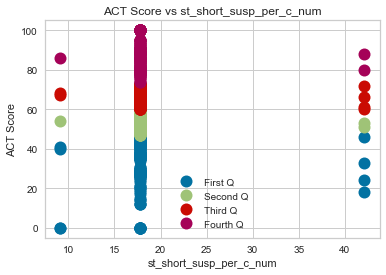

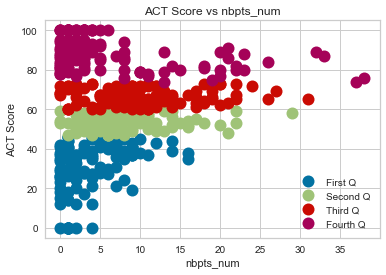

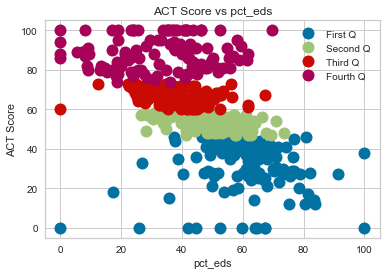

In [18]:
quartile = {0: "First Q", 1: "Second Q", 2: "Third Q", 3: "Fourth Q"}

# scatter plot code from: https://stackoverflow.com/questions/21654635/scatter-plots-in-pandas-pyplot-how-to-plot-by-category
groups = dfDropped.groupby('ACT_Score_Quartiles')

for feat in featCols:
    fig, ax = plt.subplots()
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    for name, group in groups:
        ax.plot(getattr(group, feat), group.ACT_Score, marker='o', 
                    linestyle='', ms=12, label=quartile[name])
    ax.legend()
    ax.set(title='ACT Score vs ' + feat, 
               xlabel=feat,
               ylabel='ACT Score')

    plt.show()

<a href="#top">Back to Top</a> 
## Modeling and Evaluation (50 points total)

<span style="color: blue">Different tasks will require different evaluation methods. Be as thorough as possible when analyzing the data you have chosen and use visualizations of the results to explain the performance and expected outcomes whenever possible. Guide the reader through your analysis with plenty of discussion of the results. Each option is broken down by: 

<ul style = "color: blue">
<li>Train and Adjust Parameters</li>
<li>Evaluate and Compare</li>
<li>Visualize Results</li>
<li>Summarize the Ramifications</li>


<ul style="color: blue">
<li><strong>Option A: Cluster Analysis</strong></li>
    <ul style="color: blue">
    <li><strong>Train</strong>: Perform cluster analysis using several clustering methods (adjust parameters).</li>
    <li><strong>Eval</strong>: Use internal and/or external validation measures to describe and compare the clusterings and the clusters — how did you determine a suitable number of clusters for each method?</li>
    <li><strong>Visualize</strong>: Use tables/visualization to discuss the found results. Explain each visualization in detail.</li>
    <li><strong>Summarize</strong>: Describe your results. What findings are the most interesting and why?</li>
    </ul></ul>

<ul style="color: blue">
<li><strong>Option B: Association Rule Mining</strong></li>
    <ul style="color: blue">
    <li><strong>Train</strong>: Create frequent itemsets and association rules (adjust parameters).</li>
    <li><strong>Eval</strong>: Use several measure for evaluating how interesting different rules are.</li>
    <li><strong>Visualize</strong>: Use tables/visualization to discuss the found results.</li>
<li><strong>Summarize</strong>: Describe your results. What findings are the most interesting and why?</li>
    </ul></ul>

<ul style = "color: blue">
<li><strong>Option C: Collaborative Filtering</strong></li>
    <ul style="color: blue">
    <li><strong>Train</strong>: Create user-item matrices or item-item matrices using collaborative filtering (adjust parameters).</li>
    <li><strong>Eval</strong>: Determine performance of the recommendations using different performance measures (explain the ramifications of each measure).</li>
    <li><strong>Visualize</strong>: Use tables/visualization to discuss the found results. Explain each visualization in detail.</li>
    <li><strong>Summarize</strong>: Describe your results. What findings are the most interesting and why?</li>

| Method name                  | Parameters                                 | Scalability                                                 | Best Use Case                                                                   | Geometry/Measurement Metric                       |
|------------------------------|--------------------------------------------|-------------------------------------------------------------|---------------------------------------------------------------------------|----------------------------------------------|
| K-Means                      | number of clusters                         | Very large n_samples, medium n_clusters with MiniBatch code | General-purpose, even cluster size, flat geometry, not too many clusters  | Distances between points                     |
| DBSCAN                       | neighborhood size                          | Very large n_samples, medium n_clusters                     | Non-flat geometry, uneven cluster sizes                                   | Distances between nearest points             |
| Agglomerative clustering     | number of clusters, linkage type, distance | Large n_samples and n_clusters                              | Many clusters, possibly connectivity constraints, non Euclidean distances | Any pairwise distance                        |
| Ward hierarchical clustering | number of clusters                         | Large n_samples and n_clusters                              | Many clusters, possibly connectivity constraints                          | Distances between points                     |
| Spectral clustering          | number of clusters                         | Medium n_samples, small n_clusters                          | Few clusters, even cluster size, non-flat geometry                        | Graph distance (e.g. nearest-neighbor graph) |
| Gaussian mixtures            | many                                       | Not scalable                                                | Flat geometry, good for density estimation                                | Mahalanobis distances to centers             |

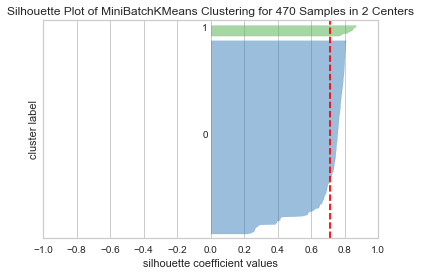

For n_clusters = 2 The average silhouette_score is : 0.7139229234302018


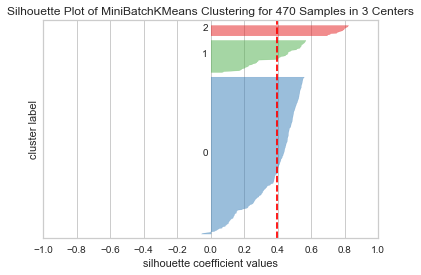

For n_clusters = 3 The average silhouette_score is : 0.3229666573681256


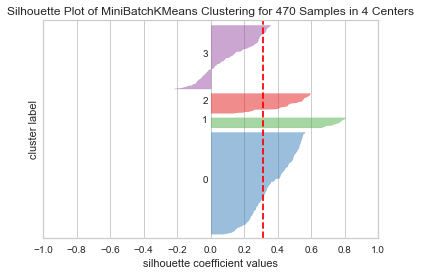

For n_clusters = 4 The average silhouette_score is : 0.30188204022734033


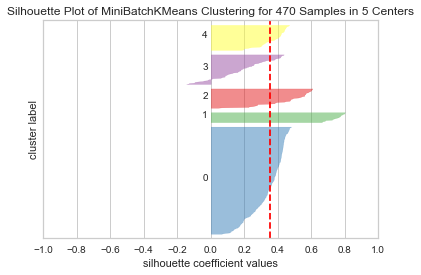

For n_clusters = 5 The average silhouette_score is : 0.2830380002864608


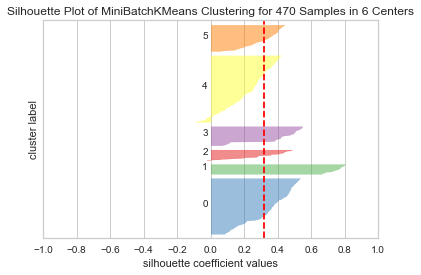

For n_clusters = 6 The average silhouette_score is : 0.24484314229998447


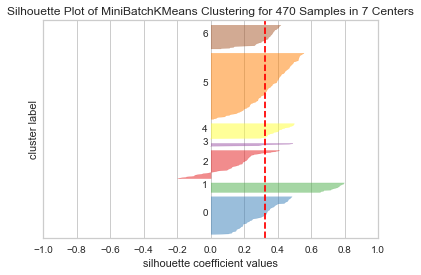

For n_clusters = 7 The average silhouette_score is : 0.3059276124548076


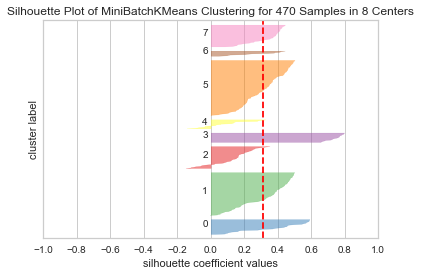

For n_clusters = 8 The average silhouette_score is : 0.3301109281654813


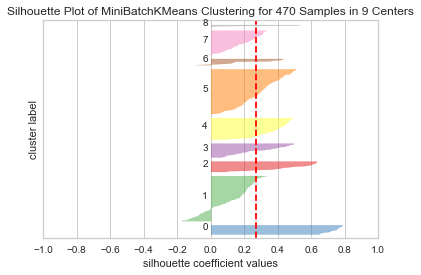

For n_clusters = 9 The average silhouette_score is : 0.3377003059804327


In [23]:
for kSize in np.arange(2,10):
    fig, ax = plt.subplots()
    model = MiniBatchKMeans(kSize)
    cLabels = model.fit_predict(dfDropped)
    model.
    silAvg = silhouette_score(dfDropped, cLabels)
    vis = SilhouetteVisualizer(model)

    vis.fit(dfDropped)
    vis.poof()
    
    print("For n_clusters =", kSize,
          "The average silhouette_score is :", silAvg)

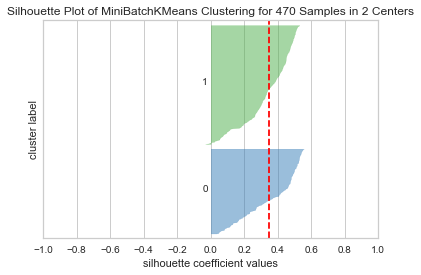

For n_clusters = 2 The average silhouette_score is : 0.35059113968556144


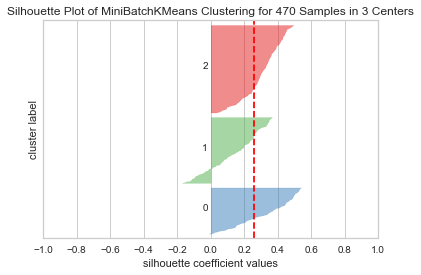

For n_clusters = 3 The average silhouette_score is : 0.28191640339272533


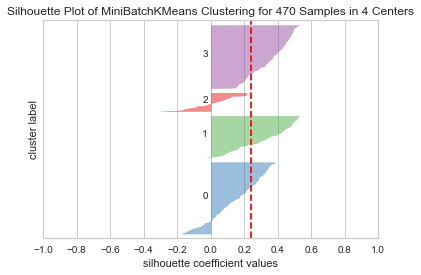

For n_clusters = 4 The average silhouette_score is : 0.3489287481254268


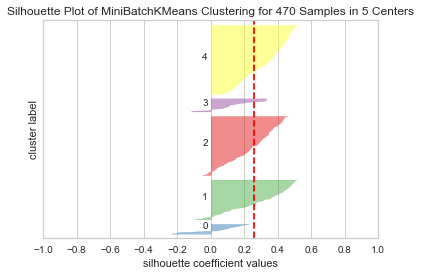

For n_clusters = 5 The average silhouette_score is : 0.2654176579163707


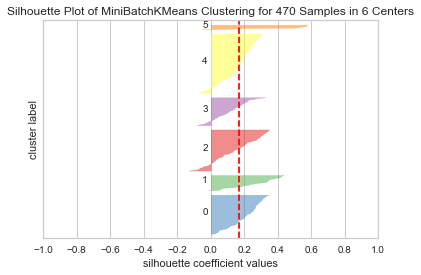

For n_clusters = 6 The average silhouette_score is : 0.2193581936695397


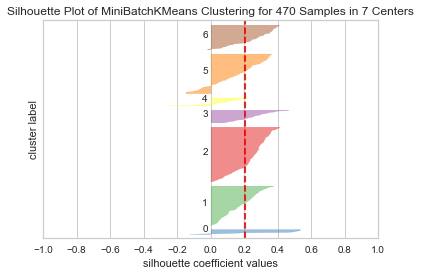

For n_clusters = 7 The average silhouette_score is : 0.2281038760793411


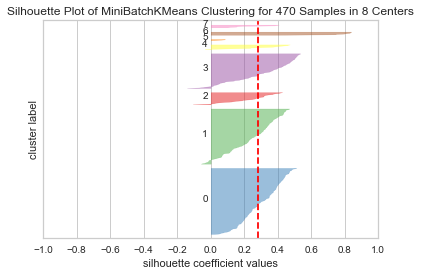

For n_clusters = 8 The average silhouette_score is : 0.18139339974832502


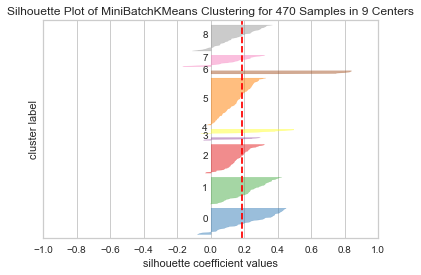

For n_clusters = 9 The average silhouette_score is : 0.21544071674473497


In [22]:
for kSize in np.arange(2,10):
    fig, ax = plt.subplots()
    model = MiniBatchKMeans(kSize)
    cLabels = model.fit_predict(dfDropped[featCols])
    silAvg = silhouette_score(dfDropped[featCols], cLabels)
    vis = SilhouetteVisualizer(model)

    vis.fit(dfDropped[featCols])
    vis.poof()
    
    print("For n_clusters =", kSize,
          "The average silhouette_score is :", silAvg)

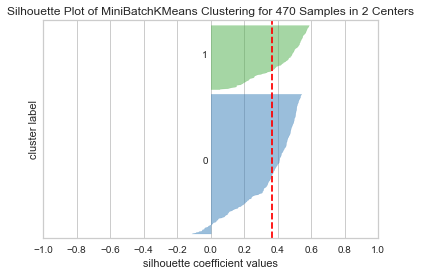

For n_clusters = 2 The average silhouette_score is : 0.35014002456332083


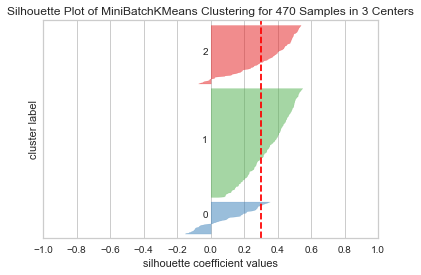

For n_clusters = 3 The average silhouette_score is : 0.25478046192172393


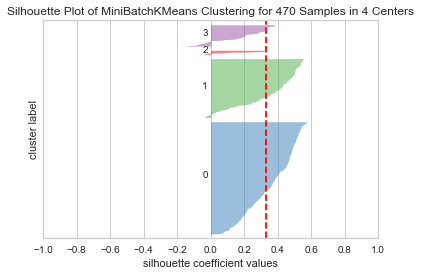

For n_clusters = 4 The average silhouette_score is : 0.24792711651139052


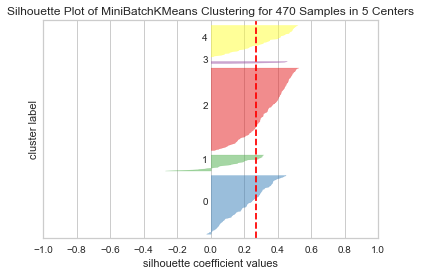

For n_clusters = 5 The average silhouette_score is : 0.21157565228730169


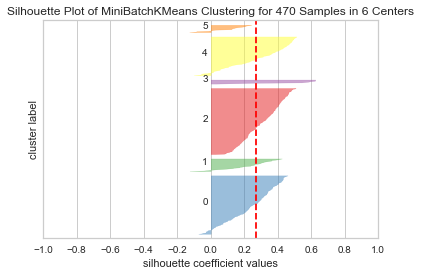

For n_clusters = 6 The average silhouette_score is : 0.2152094940564547


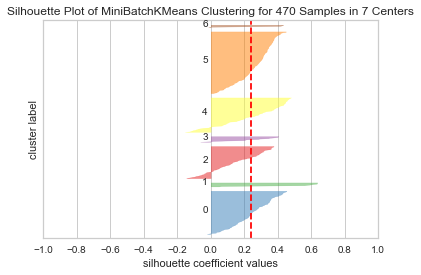

For n_clusters = 7 The average silhouette_score is : 0.24820095067974227


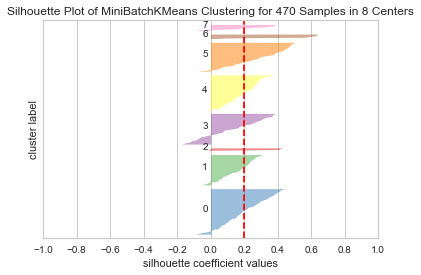

For n_clusters = 8 The average silhouette_score is : 0.19694273438151408


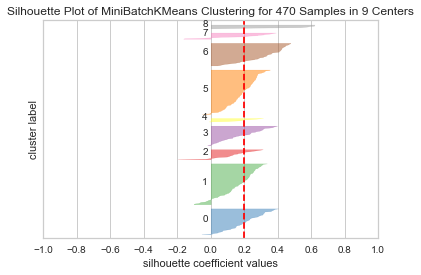

For n_clusters = 9 The average silhouette_score is : 0.21019632518065115


In [29]:
dfExtremes = dfDropped[(dfDropped['Q25'] == 1) | (dfDropped['Q100'] == 1)]

for kSize in np.arange(2,10):
    fig, ax = plt.subplots()
    model = MiniBatchKMeans(kSize)
    cLabels = model.fit_predict(dfExtremes[featCols])
    silAvg = silhouette_score(dfExtremes[featCols], cLabels)
    vis = SilhouetteVisualizer(model)

    vis.fit(dfExtremes[featCols])
    vis.poof()
    
    print("For n_clusters =", kSize,
          "The average silhouette_score is :", silAvg)

In [49]:
clsRF = RandomForestRegressor(n_estimators=10)
cv = ShuffleSplit(n_splits=10, test_size=.2, random_state=42)
dfAll = dfDropped.drop(['ACT_Score'], axis = 1)
y = dfDropped['ACT_Score']

model = MiniBatchKMeans(2)
cLabels = model.fit_predict(dfExtremes[featCols])
dfCluster = np.column_stack((dfExtremes[featCols], pd.get_dummies(cLabels)))

EvaluateRegressionEstimator(clsRF, dfCluster, dfExtremes['ACT_Score'], cv = cv)
EvaluateRegressionEstimator(clsRF, dfExtremes[featCols], dfExtremes['ACT_Score'], cv = cv)
EvaluateRegressionEstimator(clsRF, dfDropped[featCols], y, cv = cv )
EvaluateRegressionEstimator(clsRF, dfAll, y, cv = cv)

The average MAE for all cv folds is: 			 7.2474
The average MAE percentage (MAPE) for all cv folds is: 	 13.271
The average RMSE for all cv folds is: 			 10.903
*********************************************************
Cross Validation Fold Mean Error Scores
The average MAE for all cv folds is: 			 7.3312
The average MAE percentage (MAPE) for all cv folds is: 	 13.485
The average RMSE for all cv folds is: 			 10.861
*********************************************************
Cross Validation Fold Mean Error Scores
The average MAE for all cv folds is: 			 7.4039
The average MAE percentage (MAPE) for all cv folds is: 	 13.544
The average RMSE for all cv folds is: 			 11.274
*********************************************************
Cross Validation Fold Mean Error Scores
The average MAE for all cv folds is: 			 4.3172
The average MAE percentage (MAPE) for all cv folds is: 	 9.0141
The average RMSE for all cv folds is: 			 5.5619
*********************************************************
Cros

,MAE,MAPE,RMSE
0,4.496809,8.833281,5.521284
1,4.618085,9.921235,6.186920
2,4.414894,10.095910,5.575478
3,3.752128,6.688388,4.676071
4,4.057447,9.435692,5.154733
5,4.032979,7.712652,5.007239
6,4.630851,10.714541,5.689249
7,4.331915,8.922398,5.494214
8,4.152128,8.399153,5.651840
9,4.685106,9.417769,6.661544


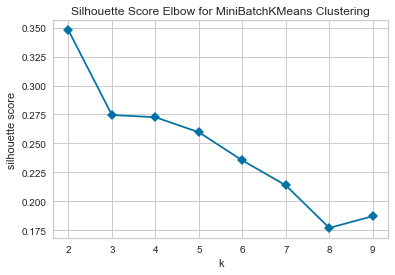

In [24]:
fig, ax = plt.subplots()
model = MiniBatchKMeans()
vis = KElbowVisualizer(model, k=(2,10), metric='silhouette', timings=False)

vis.fit(dfExtremes[featCols])
vis.poof()

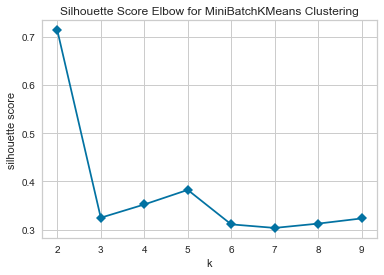

In [26]:
fig, ax = plt.subplots()
model = MiniBatchKMeans()
vis = KElbowVisualizer(model, k=(2,10), metric='silhouette', timings=False)

vis.fit(dfExtremes)
vis.poof()

<a href="#top">Back to Top</a> 
<a id="Model1"></a>
### Train and Adjust Parameters (10 points)

<a href="#top">Back to Top</a> 
<a id="Model2"></a>
### Evaluate and Compare (10 points)

<a href="#top">Back to Top</a> 
<a id="Model3"></a>
### Visualize Results (10 points)

<a href="#top">Back to Top</a> 
<a id="Model4"></a>
### Summarize the Ramifications (20 points)

<a href="#top">Back to Top</a> 
<a id="Deployment"></a>
## Deployment

<span style="color: blue">Be critical of your performance and tell the reader how *your* current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling?

<ul style="color: blue">
<li>How useful is your model for interested parties (i.e., the companies of organizations that might want to use it)?</li>
<li>How would *you* deploy your model for interested parties?</li>
<li>What other data should be collected</li>
<li>How often would the model need to be updated, etc. ?</li>

<a href="#top">Back to Top</a> 
<a id="Exceptional"></a>
## Exceptional Work (10 points total)

<span style="color: blue">You have free reign to provide additional analyses or combine analyses.